## Create and Run MCNP simulations - Windows version

The worm script must be run seperately in Cygwin using the command

\>\>perl worm HPGe_model

From the FinalModel folder.  The the runMCNP.bat can be run from the same directory:

\>\> runMCNP.bat

In [36]:
from GeneralNuclear.MCNP import batchmaker
from subprocess import Popen

batchmaker('ValidationSimulations/', inputSuffix="in", tasks=2)

Skipping file: Archive
Skipping file: HPGe_model
Skipping file: HPGe_model_2_1_1.o
Skipping file: HPGe_model_2_1_18.o
Skipping file: HPGe_model_2_2_1.o
Skipping file: HPGe_model_2_2_18.o
Skipping file: HPGe_model_2_3_1.o
Skipping file: HPGe_model_2_3_18.o
Skipping file: HPGe_model_2_4_1.o
Skipping file: HPGe_model_2_4_18.o
Skipping file: HPGe_model_2_5_1.o
Skipping file: HPGe_model_2_5_18.o
Skipping file: HPGe_model_line_pos_z_key
Skipping file: runMCNP.bat
Skipping file: worm


## Create and Run MCNP simulations

The following cell works on linux (but hasn't been tested)

In [ ]:
from GeneralNuclear.MCNP import batchmaker
from subprocess import Popen

Popen('perl ValidationSimulations/worm Final/HPGe_model')
batchmaker('ValidationSimulations/', inputSuffix="in", scriptType='sh')
Popen('./ ValidationSimulations/runMCNP.sh')

## Read and Store the Tally Results


In [37]:
import os
import pandas as pd
from GeneralNuclear.MCNP import read_tally

# Energy index map (from worm input)
energy = [59.54, 661.657]
x = [-2.5, 0, 2.5, 0, 0] 
y = [0, 2.5, 0, -2.5, 0] 

# Create dataframe
model = pd.DataFrame(columns=['energy', 'x', 'y', 'z', 'eff', 'sigma'], dtype=float)

for filename in os.listdir('FinalModel/'):
    splitFile = filename.split('.')
    if splitFile[-1] == 'o':
        print filename
        splitFile = filename.split('_')
        tmpTally = read_tally('FinalModel/'+filename, 8, readGroups=True)[0]
        
        # Loop over tally to find the data corresponding to the peak and store
        for index, row in tmpTally.iterrows():
            if float(row[0]) > energy[int(splitFile[2])-1]/1000.:
                tally = float(row[1])
                uncert = float(row[2])
                break
                
        model = model.append(pd.Series([energy[int(splitFile[2])-1], x[int(splitFile[3])-1], y[int(splitFile[3])-1], 
                                        float(splitFile[4].split('.')[0]), tally, tally*uncert], 
                                       index=['energy', 'x', 'y', 'z', 'eff', 'sigma']), ignore_index=True)

model.sort_values('y', inplace=True)
model.sort_values('x', inplace=True)
model.sort_values('z', inplace=True)
model.sort_values('energy', inplace=True)
print model

HPGe_model_2_1_1.o
HPGe_model_2_1_18.o
HPGe_model_2_2_1.o
HPGe_model_2_2_18.o
HPGe_model_2_3_1.o
HPGe_model_2_3_18.o
HPGe_model_2_4_1.o
HPGe_model_2_4_18.o
HPGe_model_2_5_1.o
HPGe_model_2_5_18.o
    energy    x    y     z       eff     sigma
0  661.657 -2.5  0.0   1.0  0.032850  0.000164
6  661.657  0.0 -2.5   1.0  0.032667  0.000163
8  661.657  0.0  0.0   1.0  0.043415  0.000187
2  661.657  0.0  2.5   1.0  0.032848  0.000164
4  661.657  2.5  0.0   1.0  0.032578  0.000163
1  661.657 -2.5  0.0  18.0  0.001641  0.000009
7  661.657  0.0 -2.5  18.0  0.001630  0.000009
9  661.657  0.0  0.0  18.0  0.001662  0.000009
3  661.657  0.0  2.5  18.0  0.001640  0.000009
5  661.657  2.5  0.0  18.0  0.001623  0.000009


## Read Experimental Data Results

In [38]:
import pandas as pd

data = pd.read_excel('Cs137Data.xlsx', parse_cols='A,B,C,D,Q,R',
                     names=['energy', 'x', 'y', 'z', 'eff', 'sigma'])

data.sort_values('y', inplace=True)
data.sort_values('x', inplace=True)
data.sort_values('z', inplace=True)
data.sort_values('energy', inplace=True)
print data

    energy    x    y   z       eff     sigma
7  661.657 -2.5  0.0   1  0.032819  0.000531
5  661.657  0.0 -2.5   1  0.030298  0.000497
6  661.657  0.0  0.0   1  0.041852  0.000751
9  661.657  0.0  2.5   1  0.036693  0.000619
8  661.657  2.5  0.0   1  0.032796  0.000549
2  661.657 -2.5  0.0  18  0.001639  0.000025
0  661.657  0.0 -2.5  18  0.001629  0.000025
1  661.657  0.0  0.0  18  0.001660  0.000026
4  661.657  0.0  2.5  18  0.001627  0.000025
3  661.657  2.5  0.0  18  0.001636  0.000025


## Plot the Results

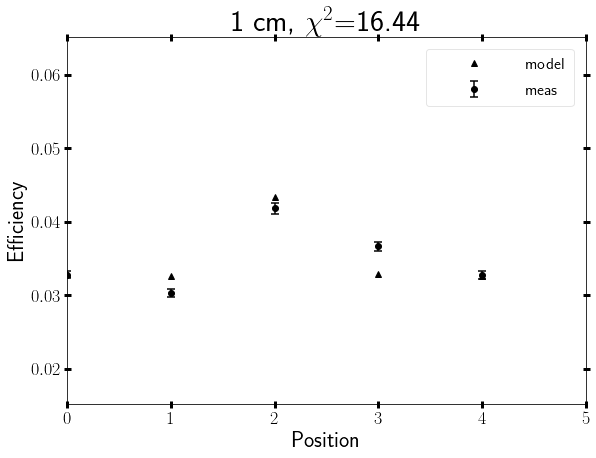

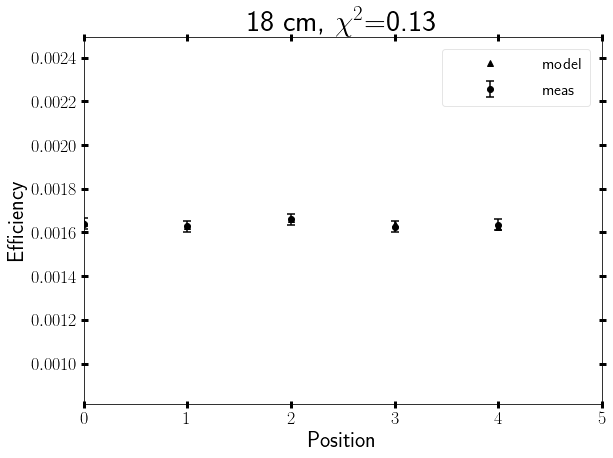

In [39]:
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline

from Support.Plotting import scatter_plot
from DataAnalysis.Stats import red_chisq

shelfPoints = 5
numShelves = 2

for s in range(1, numShelves+1):
    shelf = data[(s-1)*shelfPoints:s*shelfPoints]['z'].tolist()[0]
    xData = range(0, shelfPoints)
    yData = data[(s-1)*shelfPoints:s*shelfPoints]['eff'].tolist()
    yMod = model[(s-1)*shelfPoints:s*shelfPoints]['eff'].tolist()
    ySig = data[(s-1)*shelfPoints:s*shelfPoints]['sigma'].tolist()
    redChi2 = red_chisq(yData, yMod, standDev=ySig, freeParams=1)
    scatter_plot([xData, yData, ySig], [xData, yMod], dataLabel=['meas', 'model'],
                 xLabel='Position', yLabel='Efficiency', title='{} cm, $\chi^2$={:3.2f}'.format(shelf, redChi2))